In [1]:
import math
from datetime import datetime, timedelta
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def get_subdomains(ni, nj, n_procs):
    """Dato il numero di punti e il numero di processi, restituisce
    un generatore che fornisce i possibili sottodomini di
    dimensione >=5 per ogni lato.
    Ogni elemento è composto da
    - numero di suddivisioni lungo asse X della griglia
    - numero di suddivisioni lungo asse Y della griglia
    - numero di punti per ogni sottodominio lungo asse X
    - numero di punti per ogni sottodominio lungo asse Y
    I sottodomini non devono coprire completamente la griglia: i punti
    rimanenti saranno ripartiti in modo opportuno del modello.
    """
    for ny in range(1, n_procs + 1):
        if n_procs % ny == 0:
            nx = n_procs // ny
            dx = ni // nx
            dy = ni // ny
            if dx >= 5 and dy >= 5:
                yield nx, ny, dx, dy
                
                
def calculate_estimated_duration(grid_step, ni, nj, n_procs, single_precision, physics_on):
    return math.prod([
        72,
        #(20 / grid_step) ** 3,
        #403776 / (500 * 500),
        20/grid_step,
        ni*nj/403776,
        864 / n_procs,
        1 - 0.3 * single_precision,
        1 - 0.3 * (1 - physics_on)
    ])

def calculate_parallel_duration(df):
    duration = []
    for n_nodes, grp in df.groupby("n_nodes"):
        n_parallel = 60 // n_nodes
        n_groups = math.ceil(len(grp) / n_parallel)
        grp = grp.sort_values("estimated_duration", ascending=False)
        for idx in range(n_groups):
            start = n_parallel * idx
            end = start + n_parallel
            duration.append(grp.iloc[start:end].estimated_duration.max())
            
    return sum(duration)
                
                
def create_dataset(bbox_x_length=10000, bbox_y_length=10000):
    n_nodes_range = range(10, 61)
    n_cores_range = range(10, 37, 2)
    min_grid_step = 100
    #bbox = [0] * 2 + [min_grid_step * 100] * 2
    #bbox_x_length = abs(bbox[2] - bbox[0])
    #bbox_y_length = abs(bbox[3] - bbox[1])
    grid_step_range = [
        gs for gs in range(10, min_grid_step + 1)
        if bbox_x_length % gs == 0 and bbox_y_length % gs == 0
    ]
    bbox = [0, bbox_x_length, 0, bbox_y_length]
    dataset = []
    for grid_step in grid_step_range:
        # number of points along a parallel
        ni = bbox_x_length // grid_step
        # number of points along a meridian
        nj = bbox_y_length // grid_step
        for n_nodes in n_nodes_range:
            for n_cores in n_cores_range:
                n_procs = n_nodes * n_cores
                for nx, ny, dx, dy, in get_subdomains(ni, nj, n_procs):
                    for single_precision in (0, 1):
                        for physics_on in (0, 1):
                            estimated_duration = calculate_estimated_duration(grid_step, ni, nj, n_procs, single_precision, physics_on)
                            dataset.append([
                                bbox_x_length,
                                bbox_y_length,
                                grid_step,
                                ni,
                                nj,
                                n_nodes,
                                n_cores,
                                n_procs,
                                dx,
                                dy,
                                nx,
                                ny,
                                dx/dy,
                                single_precision,
                                physics_on,
                                estimated_duration,
                            ])
    df = pd.DataFrame(dataset, columns=[
        "x_length",
        "y_length",
        "grid_step",
        "ni",
        "nj",
        "n_nodes",
        "n_cores",
        "n_procs",
        "dx",
        "dy",
        "nx",
        "ny",
        "subdomain_ratio",
        "single_precision",
        "physics_on",
        "estimated_duration"
    ])
    return df

Sono presi in considerazione solo gli esperimenti in cui
- il rapporto tra x e y del sottodominio è tra 1 e 5
- i passi di griglia sono 20, 50, 80 e 100
- il numero di core per node è maggiore di 14
- il tempo di esecuzione stimato è <= 500 secondi

In [2]:
QUERY = " and ".join([
    "subdomain_ratio >= 1",
    "subdomain_ratio <= 5",
    "estimated_duration <= 500",
    "grid_step in [20, 50, 80, 100]",
    "n_cores > 14"
])

Il dataset 1 contiene tutti gli esperimenti all'interno della griglia 10x10 gradi che rispettano il precedente filtro.

In [3]:
df1 = create_dataset()
df1 = df1.query(QUERY)
print("Tempo complessivo di esecuzione:", timedelta(seconds=df1.estimated_duration.sum()))
print("Tempo complessivo di esecuzione in parallelo", timedelta(seconds=calculate_parallel_duration(df1)))
print("Tempo complessivo di esecuzione al giorno:", timedelta(seconds=df1.estimated_duration.sum()/30))
print("Tempo di esecuzione di cosmo 5M med (33s):", calculate_estimated_duration(45, 1083, 559, 928, 0, 1))
df1.describe()

Tempo complessivo di esecuzione: 3 days, 2:42:30.402173
Tempo complessivo di esecuzione in parallelo 1 day, 19:33:20.034311
Tempo complessivo di esecuzione al giorno: 2:29:25.013406
Tempo di esecuzione di cosmo 5M med (33s): 44.66995425254562


,x_length,y_length,grid_step,ni,nj,n_nodes,n_cores,n_procs,dx,dy,nx,ny,subdomain_ratio,single_precision,physics_on,estimated_duration
count,10512.0,10512.0,10512.000000,10512.000000,10512.000000,10512.000000,10512.000000,10512.000000,10512.000000,10512.000000,10512.000000,10512.000000,10512.000000,10512.000000,10512.000000,10512.000000
mean,10000.0,10000.0,35.064688,373.734779,373.734779,31.017123,25.473364,791.374429,20.208143,9.876332,20.365297,37.870244,2.132287,0.500000,0.500000,25.585084
std,0.0,0.0,20.966006,157.299683,157.299683,14.805371,6.410412,437.952449,11.841839,4.889836,7.371912,14.347479,1.071391,0.500024,0.500024,28.672838
min,10000.0,10000.0,20.000000,100.000000,100.000000,10.000000,16.000000,160.000000,5.000000,5.000000,7.000000,15.000000,1.000000,0.000000,0.000000,0.377461
25%,10000.0,10000.0,20.000000,200.000000,200.000000,18.000000,20.000000,432.000000,11.000000,6.000000,15.000000,28.000000,1.250000,0.000000,0.000000,3.027254
50%,10000.0,10000.0,20.000000,500.000000,500.000000,29.000000,24.000000,704.000000,18.000000,9.000000,20.000000,36.000000,1.800000,0.500000,0.500000,18.723252
75%,10000.0,10000.0,50.000000,500.000000,500.000000,42.000000,30.000000,1064.000000,27.000000,12.000000,25.000000,45.000000,2.750000,1.000000,1.000000,36.473868
max,10000.0,10000.0,100.000000,500.000000,500.000000,60.000000,36.000000,2160.000000,71.000000,33.000000,45.000000,99.000000,5.000000,1.000000,1.000000,240.727532


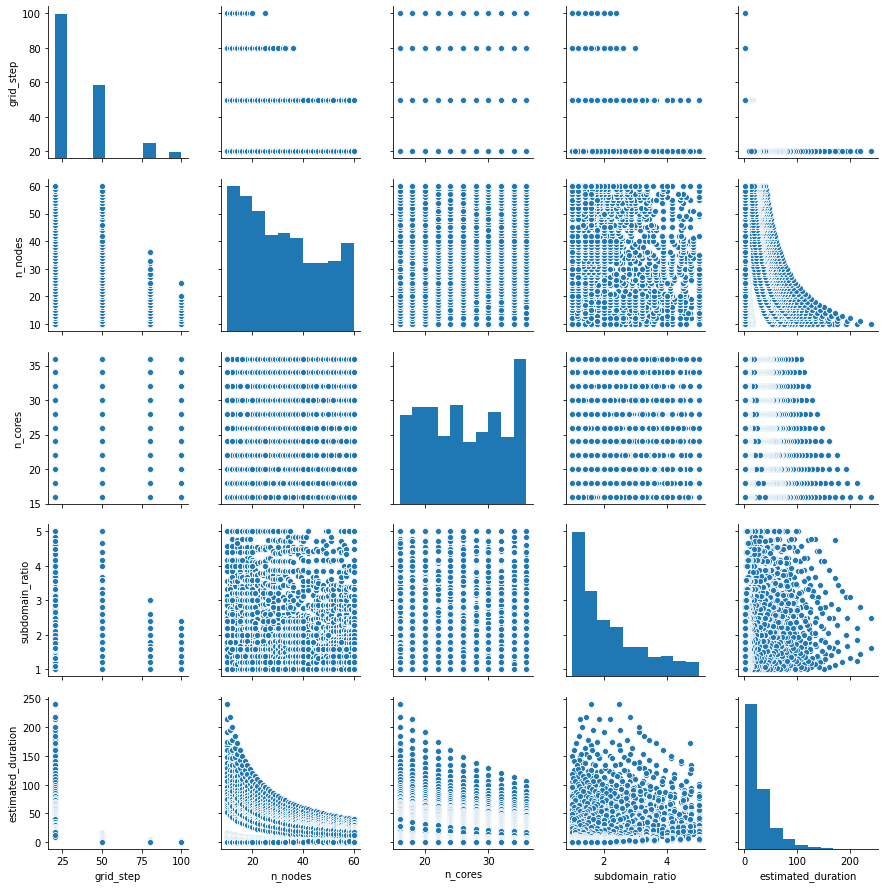

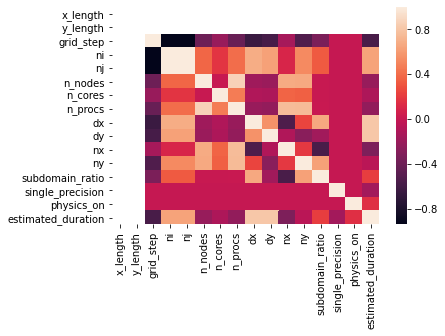

In [4]:
sns.pairplot(df1, vars=[
    "grid_step", "n_nodes", "n_cores", "subdomain_ratio", "estimated_duration",
])
plt.show()
sns.heatmap(df1.corr())
plt.show()

Il dataset 2 contiene 800 esperimenti casuali per ogni diversa griglia (tra cui quelli della griglia del dataset 1).

In [5]:
n_samples = 1000
df2 = pd.concat([
    d.query(QUERY).sample(n_samples)
    for d in [
        create_dataset(bbox_x_length=x, bbox_y_length=y)
        for x, y in (
            (48000, 15000),
            (30000, 12000),
            (12000, 25000),
        )
    ]
])
print(df2.describe())
print("Numero totale di esempi:", df2.shape[0])
print("Tempo complessivo di esecuzione:", timedelta(seconds=df2.estimated_duration.sum()))
print("Tempo complessivo di esecuzione in parallelo", timedelta(seconds=calculate_parallel_duration(df2)))
print("Tempo complessivo di esecuzione al giorno:", timedelta(seconds=df2.estimated_duration.sum()/30))
# Ne aggiungo 1000 da dataset 1
df2 = pd.concat([df2, df1.query(QUERY).sample(n_samples)])

           x_length      y_length    grid_step           ni           nj  \
count   3000.000000   3000.000000  3000.000000  3000.000000  3000.000000   
mean   30000.000000  17333.333333    51.400000   803.955000   528.220000   
std    14699.388559   5558.703861    30.550796   654.352358   397.463991   
min    12000.000000  12000.000000    20.000000   120.000000   120.000000   
25%    12000.000000  12000.000000    20.000000   375.000000   150.000000   
50%    30000.000000  15000.000000    50.000000   600.000000   500.000000   
75%    48000.000000  25000.000000    80.000000   960.000000   750.000000   
max    48000.000000  25000.000000   100.000000  2400.000000  1250.000000   

           n_nodes      n_cores      n_procs          dx           dy  \
count  3000.000000  3000.000000  3000.000000  3000.00000  3000.000000   
mean     34.259333    26.071333   893.158000    42.72200    19.931667   
std      14.503776     6.318139   443.695544    38.22539    17.660454   
min      10.000000    1

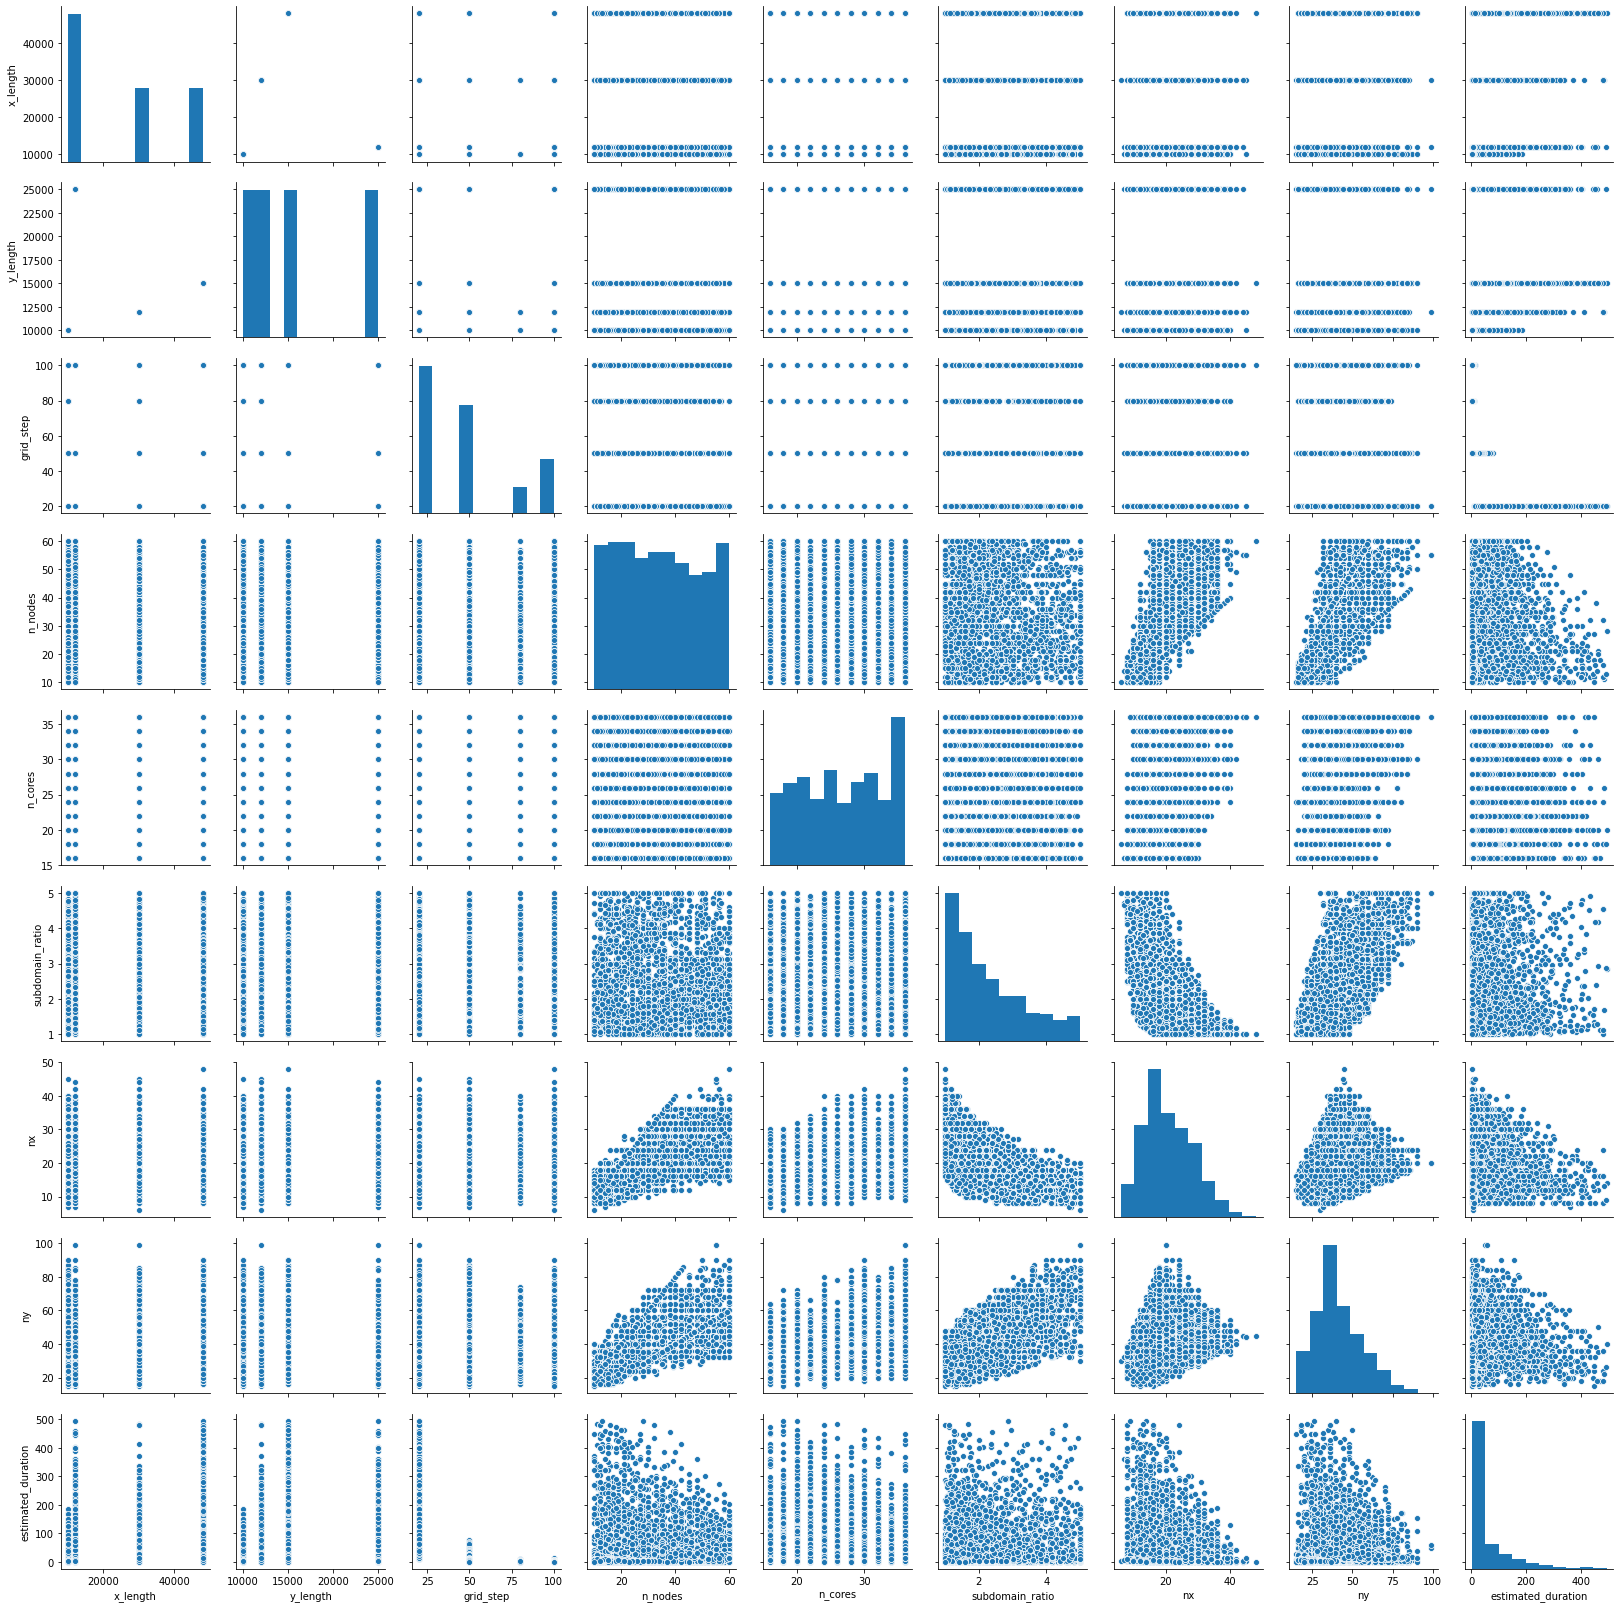

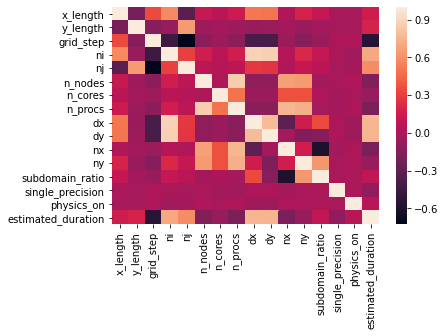

In [6]:
sns.pairplot(df2, vars=[
    "x_length", "y_length", "grid_step", "n_nodes", "n_cores", "subdomain_ratio", "nx", "ny", "estimated_duration",
])
plt.show()
sns.heatmap(df2.corr())
plt.show()